##Imports

In [ ]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

##Policy network

In [ ]:
class Policy(nn.Module):
    def __init__(self,seed, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

## REINFORCE - w/o baseline function

In [ ]:
def reinforce(env_name,seed=0,h_size=16,average_reward_lim=195,n_episodes=10000, max_t=1000, gamma=0.99, print_every=100,print_flag=True,alpha=1e-2):
    env = gym.make(env_name)
    env.seed(seed)
    policy = Policy(seed,env.observation_space.shape[0],h_size,env.action_space.n)
    optimizer = optim.Adam(policy.parameters(), lr=alpha)
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0 and print_flag:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        #if np.mean(scores_deque)>=average_reward_lim:
        #    print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
        #    break

    return scores


##REINFORCE w/o baseline - test runs

In [ ]:
#13min - 5000ep - 1e-3 - h_size=16
#4min  - 1500ep - 1e-2 - h_size=32
scores = reinforce('CartPole-v1',n_episodes=5000,alpha=1e-2,h_size=32)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 37.02
Episode 200	Average Score: 62.60
Episode 300	Average Score: 62.29
Episode 400	Average Score: 43.32
Episode 500	Average Score: 94.37
Episode 600	Average Score: 118.09
Episode 700	Average Score: 107.41
Episode 800	Average Score: 101.30
Episode 900	Average Score: 108.21
Episode 1000	Average Score: 44.07
Episode 1100	Average Score: 138.54
Episode 1200	Average Score: 69.26
Episode 1300	Average Score: 218.25


KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: -182.69
Episode 200	Average Score: -112.34
Episode 300	Average Score: -102.10
Episode 400	Average Score: -87.54
Episode 500	Average Score: -88.36
Episode 600	Average Score: -95.04
Episode 700	Average Score: -88.80
Episode 800	Average Score: -90.11
Episode 900	Average Score: -95.00
Episode 1000	Average Score: -90.71


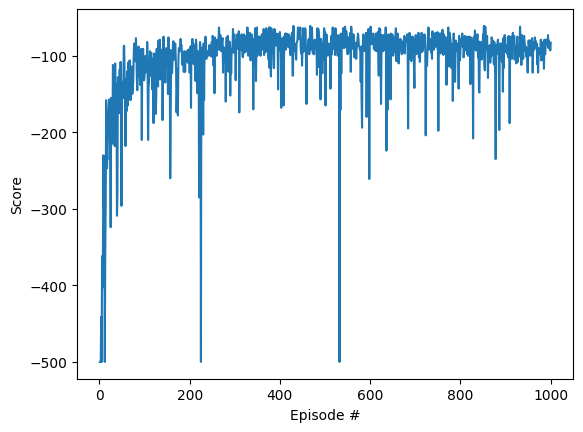

In [ ]:
#2min - 1e-2,h_size=32 - 1000ep
scores = reinforce('Acrobot-v1',alpha=1e-2,n_episodes=1000,h_size=32)#2min - 1e-2,h_size=32
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

##Cartpole - REINFORCE w/o baseline

In [ ]:
all_scores = []
for seed in range(5):
    scores = reinforce('CartPole-v1', seed=seed,print_flag=False,n_episodes=10000,alpha=1e-2,h_size=32)
    all_scores.append(scores)
all_scores_array_cp_wob = np.array(all_scores)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


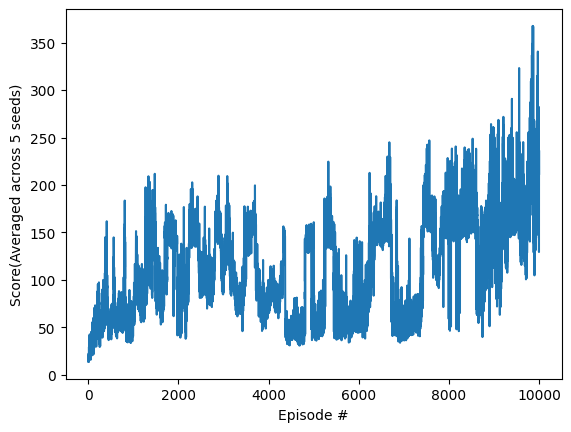

In [ ]:
average_scores = np.mean(all_scores_array_cp_wob, axis=0)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(average_scores)+1), average_scores)
plt.ylabel('Score(Averaged across 5 seeds)')
plt.xlabel('Episode #')
plt.show()

In [ ]:
np.save('all_scores_array_cp_wob.npy',all_scores_array_cp_wob)

##Acrobot - REINFORCE w/o baseline

In [ ]:
all_scores = []
for seed in range(5):
    scores = reinforce('Acrobot-v1', seed=seed,print_flag=False,n_episodes=2000,alpha=1e-2,h_size=32)
    all_scores.append(scores)
all_scores_array_ab_wob = np.array(all_scores)

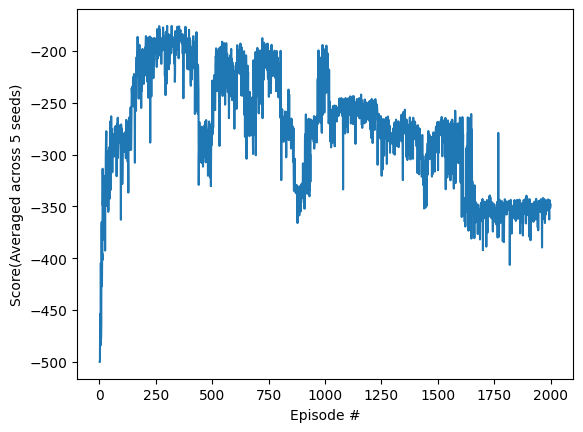

In [ ]:
average_scores = np.mean(all_scores_array_ab_wob, axis=0)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(average_scores)+1), average_scores)
plt.ylabel('Score(Averaged across 5 seeds)')
plt.xlabel('Episode #')
plt.show()

In [ ]:
np.save("all_scores_array_ab_wob.npy",all_scores_array_ab_wob)

## REINFORCE - TD(0) baseline function

In [ ]:
class Value(nn.Module):
    def __init__(self, seed, s_size=4, h_size=16):
        super(Value, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


def reinforce_with_baseline(env_name, seed=0, h_size_v=128, h_size_p=16, average_reward_lim=195, n_episodes=10000, max_t=1000, gamma=0.99, print_every=100, print_flag=True, alpha_v=1e-2, alpha_p=1e-2):
    env = gym.make(env_name)
    env.seed(seed)
    policy = Policy(seed, env.observation_space.shape[0], h_size_p, env.action_space.n)
    value_net = Value(seed, env.observation_space.shape[0], h_size_v)
    policy_optimizer = optim.Adam(policy.parameters(), lr=alpha_p)
    value_optimizer = optim.Adam(value_net.parameters(), lr=alpha_v)
    scores_deque = deque(maxlen=100)
    scores = []
    baseline_values = []  # Store baseline values

    for i_episode in range(1, n_episodes + 1):
        saved_log_probs = []
        rewards = []
        state = env.reset()

        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            state = next_state
            if done:
                break

        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        # Calculate TD(0) baseline
        value = value_net(torch.from_numpy(state).float()).squeeze().detach()
        advantage = R - value

        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * advantage)
        policy_loss = torch.cat(policy_loss).sum()

        value_loss = F.mse_loss(value_net(torch.from_numpy(state).float()).squeeze(), torch.tensor(R).expand_as(value))



        policy_optimizer.zero_grad()
        value_optimizer.zero_grad()
        policy_loss.backward()
        value_loss.backward()
        policy_optimizer.step()
        value_optimizer.step()

        baseline_values.append(value.item())  # Store baseline value

        if i_episode % print_every == 0 and print_flag:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores,baseline_values


##REINFORCE with TD(0) baseline - test runs

In [ ]:
scores,baseline = reinforce_with_baseline('CartPole-v1', seed=seed,n_episodes=1000,alpha_v=1e-2,h_size_p=32)

Episode 100	Average Score: 46.46
Episode 200	Average Score: 77.26
Episode 300	Average Score: 153.19
Episode 400	Average Score: 174.41
Episode 500	Average Score: 254.24
Episode 600	Average Score: 468.50
Episode 700	Average Score: 500.00
Episode 800	Average Score: 497.36
Episode 900	Average Score: 500.00
Episode 1000	Average Score: 500.00


In [ ]:
scores = reinforce_with_baseline('Acrobot-v1', seed=0,n_episodes=2000,alpha_p=1e-2,h_size_p=32,h_size_v=128,alpha_v=1e-2)

Episode 100	Average Score: -287.85
Episode 200	Average Score: -165.57
Episode 300	Average Score: -121.40
Episode 400	Average Score: -106.98
Episode 500	Average Score: -94.55
Episode 600	Average Score: -88.62
Episode 700	Average Score: -93.79


KeyboardInterrupt: 

##Cartpole - REINFORCE - TD(0) baseline

In [ ]:
all_scores = []
all_baseline = []
for seed in range(5):
    scores,baseline = reinforce_with_baseline(env_name='CartPole-v1', seed=seed,print_flag=False,n_episodes=1000,alpha_v=1e-2,h_size_p=32)
    all_scores.append(scores)
    all_baseline.append(baseline)
all_scores_array_cp_wtd0b = np.array(all_scores)
all_baseline_array_cp_wtd0b = np.array(all_baseline)

In [ ]:
np.save("all_scores_array_cp_wtd0b.npy",all_scores_array_cp_wtd0b)
np.save("all_baseline_array_cp_wtd0b.npy",all_baseline_array_cp_wtd0b)

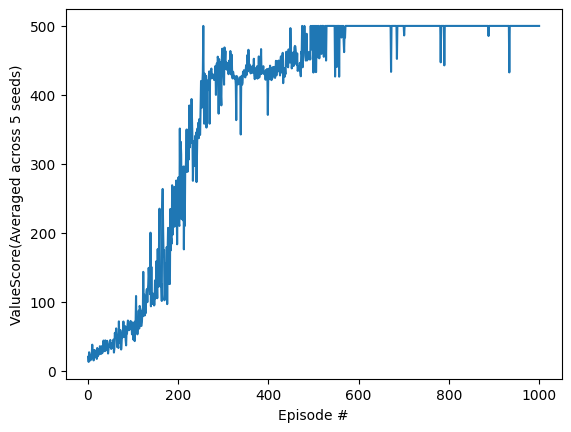

In [ ]:
average_scores = np.mean(all_scores_array_cp_wtd0b, axis=0)
average_baseline = np.mean(all_baseline_array_cp_wtd0b, axis=0)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(average_scores)+1), average_scores,label='Score(Averaged across 5 seeds)')
#plt.plot(np.arange(1, len(average_baseline)+1), average_baseline, label='Baseline Estimate(Averaged across 5 seeds)')
plt.plot()
plt.ylabel('ValueScore(Averaged across 5 seeds)')
plt.xlabel('Episode #')
plt.show()

##Acrobot - REINFORCE - TD(0) baseline

In [ ]:
all_scores = []
all_baseline = []
for seed in range(5):
    scores,baseline = reinforce_with_baseline('Acrobot-v1', seed=seed,print_flag=False,n_episodes=2000,alpha_p=1e-2,h_size_p=32,h_size_v=128,alpha_v=1e-2)
    all_scores.append(scores)
    all_baseline.append(baseline)
all_scores_array_ab_wtd0b = np.array(all_scores)
all_baseline_array_ab_wtd0b = np.array(all_baseline)

In [ ]:
np.save("all_scores_array_ab_wtd0b.npy",all_scores_array_ab_wtd0b)
np.save("all_baseline_array_ab_wtd0b.npy",all_baseline_array_ab_wtd0b)

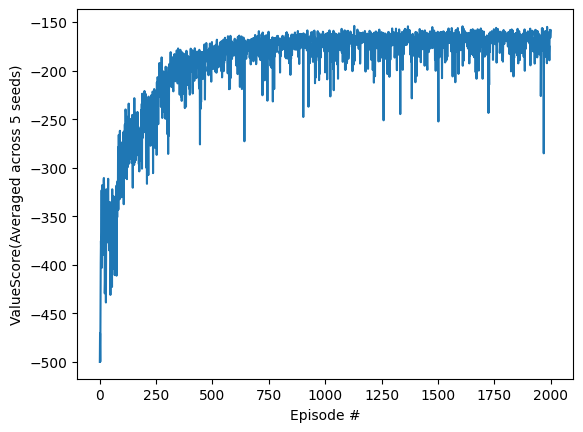

In [ ]:
average_scores = np.mean(all_scores_array_ab_wtd0b, axis=0)
average_baseline = np.mean(all_baseline_array_ab_wtd0b, axis=0)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(average_scores)+1), average_scores,label='Score(Averaged across 5 seeds)')
#plt.plot(np.arange(1, len(average_baseline)+1), average_baseline, label='Baseline Estimate(Averaged across 5 seeds)')
plt.plot()
plt.ylabel('ValueScore(Averaged across 5 seeds)')
plt.xlabel('Episode #')
plt.show()